In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import re
import time
import glob
import os
import random

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

import imutils

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()

Paths defined in paths module:
 paths.data_root: /Users/trafferty/data
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.images_root: /Users/trafferty/data/images
 paths.projects_root: /Users/trafferty/data/projects
 paths.results_root: /Users/trafferty/data/results
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.dat_root: /Users/trafferty/data/dat
 paths.tmp_dir: /Users/trafferty/tmp
 paths.ws_dir: /Users/trafferty/workspace
 paths.mii_home: /Users/trafferty/dev
 paths.inhouse: /Users/trafferty/dev/src/inhouse


### Helper Functions

In [20]:
def readRaw(filepath, rows, cols):
    try: 
        with open(filepath, 'rb') as fd:
            raw_buf = np.fromfile(fd, dtype=np.uint8, count=rows*cols)
        #raw_buf = 255-raw_buf
        return raw_buf.reshape((rows, cols)) #notice row, column format
    except FileNotFoundError:
        print("Error! File not found: %s" % (filepath))
        raise
    
def readImage(path):
    ext = path[-3:]
    if ext.lower() == 'raw' or ext.lower() == 'dat':
        raw_rows = 1088
        raw_cols = 2048
        img = readRaw(path, raw_rows, raw_cols)
    elif ext.lower() == 'bmp' or ext.lower() == 'jpg' or ext.lower() == 'png':
        img = cv2.imread(path)
#         if img.ndim == 3:
#             img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)        
    return img
    
def plot_imgs(img_data_lst, color=False, interp='none', max_cols=3, fig_size=10):
    cnt=len(img_data_lst)
    r,c,n = cnt,cnt,1
    for idx, img_data in enumerate(img_data_lst):
        if idx % max_cols == 0:
            plt.figure(figsize=(fig_size*r,fig_size*c))
        plt.subplot(r,c,idx+1)
        if color:
            #plt.imshow(img_data[0], interpolation='none', vmax=abs(img_data[0]).max(), vmin=-abs(img_data[0]).max())
            plt.imshow(img_data[0].astype(np.float), interpolation=interp)
        else:
            plt.imshow(img_data[0].astype(np.float), interpolation=interp, cmap='gray')
        plt.title('%s' % (img_data[1])), plt.xticks([]), plt.yticks([])


In [3]:
local = True
if local:
    folder_root = "/Users/trafferty/tmp/extrusion_images"
else:
    folder_root = "/Volumes/EXT/CINC/20180515"


In [4]:
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0
        
    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY, self.startX:self.endX]]

The next step when applying HED with OpenCV is to define the getMemoryShapes function, the method responsible for computing the volume size of the inputs :

Line 27 derives the shape of the input volume as well as the target shape.

Line 28 extracts the batch size and number of channels from the inputs as well.

Finally, Line 29 extracts the height and width of the target shape, respectively.

Given these variables, we can compute the starting and ending crop (x, y)-coordinates on Lines 32-35.

We then return the shape of the volume to the calling function on Line 39.

The final method we need to define is the forward function. This function is responsible for performing the crop during the forward pass (i.e., inference/edge prediction) of the network:

##### Now load the HED model from disk and setup the net (DNN):

In [5]:
model_root = f"{paths.dat_root}/holistically-nested-edge-detection/hed_model"
image_root = f"{paths.dat_root}/holistically-nested-edge-detection/images"

protoPath = f"{model_root}/deploy.prototxt"
modelPath = f"{model_root}/hed_pretrained_bsds.caffemodel"
print(protoPath)
print(modelPath)

net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
 
# register our new layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)

/Users/trafferty/data/dat/holistically-nested-edge-detection/hed_model/deploy.prototxt
/Users/trafferty/data/dat/holistically-nested-edge-detection/hed_model/hed_pretrained_bsds.caffemodel


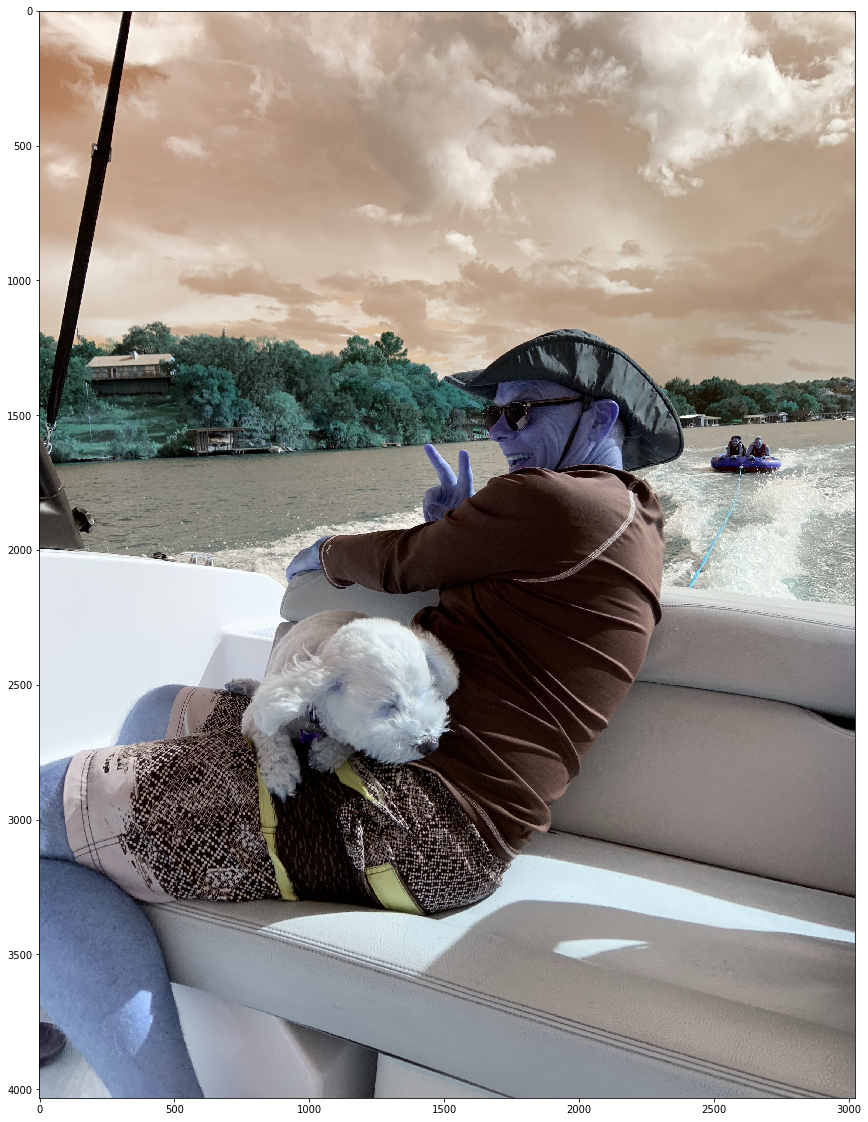

In [30]:
loc_path = '/Users/trafferty/tmp/extrusion_images/request2_renamed/-58_-15725/Field_53_-58_-15725.raw'
loc_path = '/Users/trafferty/tmp/tom_dog.png'
image =readImage( loc_path)
if image.ndim == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

#plot_imgs([ (image, "img_border RAW"), (image, "img_shifted RAW")], max_cols = 2, fig_size = 20)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(image)

[INFO] performing Canny edge detection...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


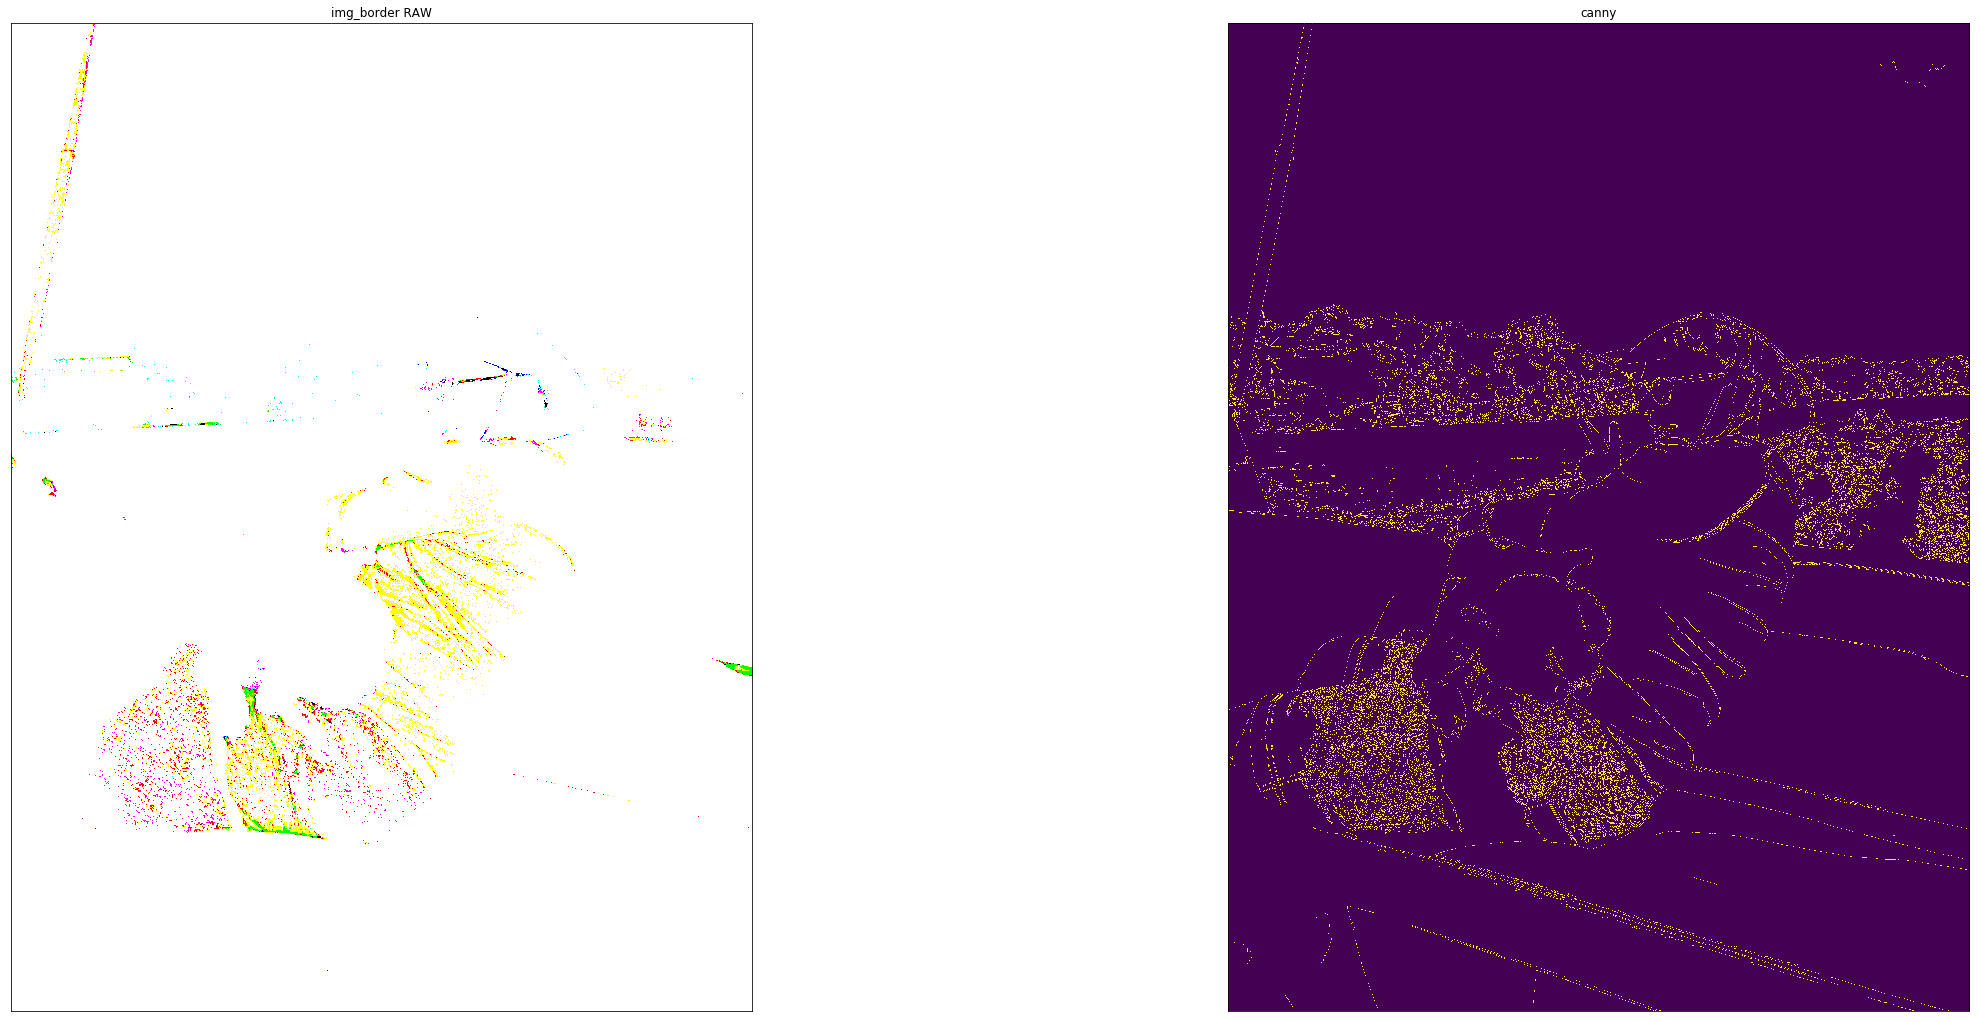

In [31]:
#image = cv2.imread(f"{image_root}/cat.jpg")
(H, W) = image.shape[:2]
 
# convert the image to grayscale, blur it, and perform Canny
# edge detection
print("[INFO] performing Canny edge detection...")
gray = image
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
canny = cv2.Canny(blurred, 30, 150)
plot_imgs([ (image, "img_border RAW"), (canny, "canny")], color=True, max_cols = 2, fig_size = 20)

[INFO] performing holistically-nested edge detection...


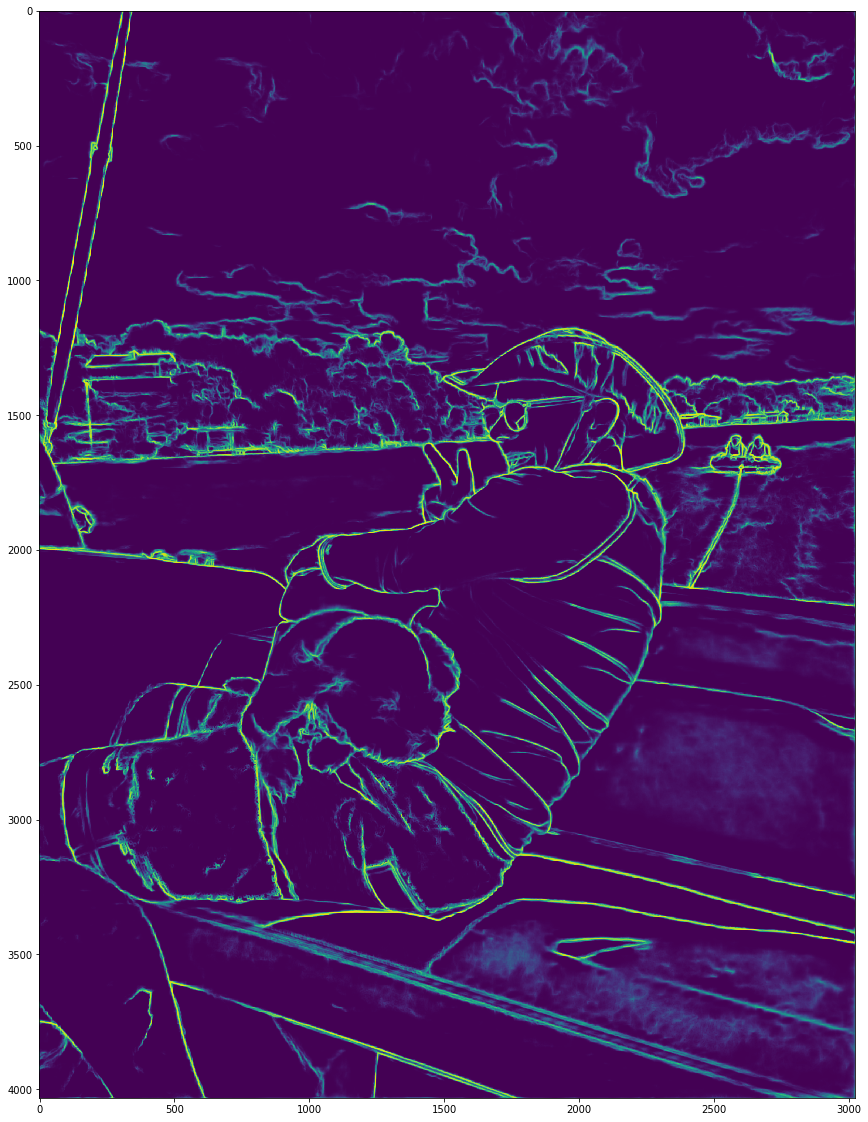

In [32]:
# construct a blob out of the input image for the Holistically-Nested
# Edge Detector
blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(W, H),mean=(104.00698793, 116.66876762, 122.67891434),swapRB=False, crop=False)
 
# set the blob as the input to the network and perform a forward pass
# to compute the edges
print("[INFO] performing holistically-nested edge detection...")
net.setInput(blob)
hed = net. forward()
hed = cv2.resize(hed[0, 0], (W, H))
hed = (255 * hed).astype("uint8")

#plot_imgs([ (image, "img_border RAW"), (hed, "HED")], color=True, max_cols = 2, fig_size = 20)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(hed)